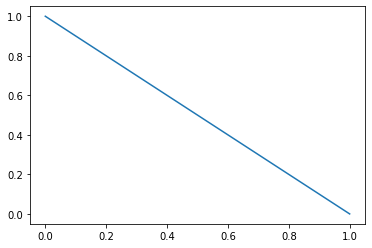

Import of general_pyNN.PYNNBackend failed due to:
No module named 'pyNN'


In [1]:
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
plt.show()

import scipy as sp
import pylab as plt
from scipy.integrate import odeint
from neo import AnalogSignal


from neo import AnalogSignal
import quantities as pq
from neuronunit.optimisation.optimization_management import inject_and_plot_model, dtc_to_rheo
from neuronunit.optimisation.optimization_management import inject_and_plot_passive_model
import numpy as np
from neuronunit.optimisation.data_transport_container import DataTC
from neuronunit.optimisation import model_parameters

In [2]:


class HodgkinHuxley():
    """Full Hodgkin-Huxley Model implemented in Python"""

    C_m  =   1.0
    """membrane capacitance, in uF/cm^2"""

    g_Na = 120.0
    """Sodium (Na) maximum conductances, in mS/cm^2"""

    g_K  =  36.0
    """Postassium (K) maximum conductances, in mS/cm^2"""

    g_L  =   0.3
    """Leak maximum conductances, in mS/cm^2"""

    E_Na =  50.0
    """Sodium (Na) Nernst reversal potentials, in mV"""

    E_K  = -77.0
    """Postassium (K) Nernst reversal potentials, in mV"""

    E_L  = -54.387
    """Leak Nernst reversal potentials, in mV"""


    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - sp.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*sp.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*sp.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0 + sp.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - sp.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*sp.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    def I_inj(self, t,constant=None):
        """
        External Current

        |  :param t: time
        |  :return: step up to 10 uA/cm^2 at t>100
        |           step down to 0 uA/cm^2 at t>200
        |           step up to 35 uA/cm^2 at t>300
        |           step down to 0 uA/cm^2 at t>400
        """
        
        return 0*(t<100) +2.240341901779175*(t>100) -2.240341901779175*(t>1100)
        #2.240341901779175 pA

    @staticmethod
    def dALLdt(X, t, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dmdt, dhdt, dndt

    def Main(self,t=None):
        """
        Main demo for the Hodgkin Huxley neuron model
        """
        if t is not None:
            self.t = t
        else:
            self.t = sp.arange(0.0, 1300.0, 0.01)
            """ The time to integrate over """

        X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)

        plt.figure()
        len(V)
        scale = len(V)/1.3
        vm = AnalogSignal(V,units = pq.V,sampling_rate = scale * pq.Hz)
        plt.title('Hodgkin-Huxley Neuron')
        plt.plot(vm.times, vm, 'k')
        plt.ylabel('V (mV)')


        plt.show()
        return vm




# HH cell from NU backend

INFO:numba.transforms:finding looplift candidates


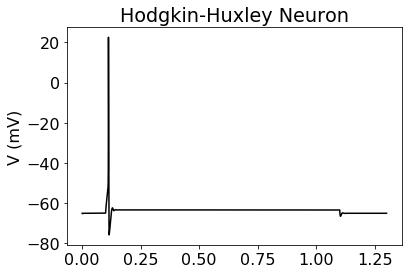

In [3]:
new_attrs = {}
new_attrs['E_L'] = -54.387
b = str("HH")
attrs = {k:np.mean(v) for k,v in model_parameters.MODEL_PARAMS[b].items()}
if new_attrs is not None:
    for k,v in new_attrs.items():
        attrs[k] = new_attrs[k]

pre_model = DataTC()

pre_model.attrs = attrs
pre_model.backend = b
vm,plt = inject_and_plot_model(pre_model.attrs,b)
from neuronunit.models import StaticModel

SM = StaticModel(vm)

dtc = dtc_to_rheo(pre_model)
SM

In [4]:
SM.vm

AnalogSignal with 1 channels of length 1300000; units mV; datatype float64 
sampling rate: 999999.9999999999
time: 0.0 to 1.3

In [7]:
from neuronunit.optimisation.optimization_management import OptMan,TSD,dtc_to_rheo#,get_neab
from neuronunit.optimisation.data_transport_container import DataTC
from neuronunit.optimisation import get_neab
import dask.bag as db

test_frame = get_neab.process_all_cells()
tt = test_frame['Neocortex pyramidal cell layer 5-6']#
for t in tt:
    print(t.name)
    t.generate_prediction = SM.vm
    score = t.judge(SM)
#tt = switch_logic(tt)
#not_suite = TSD({t.name:t for t in tt.tests})


RheobaseTest


AttributeError: Model None has no attribute run_params

# HH cell from NeuroML2 Python code

In [ ]:
#if __name__ == '__main__':
runner = HodgkinHuxley()
t = np.arange(0.0, 1300.0, 0.01)
""" The time to integrate over """

vm = runner.Main(t=t)